In [1]:
import os
import pandas as pd
import csv
import numpy as np
import time

from datetime import datetime

predicted_data_path = "/home/aayush/accelerometer/accprocess/results"
annotated_data_path = "/home/yacine/accel/capture24/participants/"
aggregated = "/home/aayush/accelerometer/accprocess/data_saved/PA3/combined"

labels_dict_location = "/home/aayush/accelerometer/accprocess/anno-label.csv"

In [3]:
def get_files(data_path, predicted_files=False, annotated_files=False) -> None:
    total_csv_zipped = []
    for path, dirnames, filenames in os.walk(data_path):

        for file in filenames:
            if file.endswith(".csv.gz") and predicted_files:
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                
            if file.endswith(".csv") and annotated_files and file[0]!='c': #ignore the capture24 file
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))

    return sorted(total_csv_zipped)

In [4]:
def create_labels_dict():
    labels_dict = {}
    with open(labels_dict_location, "r") as annotation_dict:
        reader = csv.DictReader(annotation_dict)
        for row in reader:
            if labels_dict.get(row['annotation']) is None:
                labels_dict[row['annotation']] = [row['label:Walmsley2020']]
            else:
                labels_dict[row['annotation']].append(row['label:Walmsley2020'])
    return labels_dict


def parse_datetime(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object


def parse_datetime_df_time(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    clean_datetime_str = clean_datetime_str.split('+')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object

In [5]:
predicted_data_files = get_files(data_path=predicted_data_path, predicted_files=True)
annotated_data_files = get_files(data_path=annotated_data_path, annotated_files=True)
aggregated_files = get_files(data_path=aggregated, annotated_files=True)
assert len(predicted_data_files) == len(annotated_data_files), "Number of predicted and annotated data files should be the same."
assert len(aggregated_files) == len(predicted_data_files), "Number of predicted and aggregated should be the same."

labels_dict = create_labels_dict()

labels = ["light", "moderate-vigorous", "sedentary", "sleep"]

In [6]:
cp_labels_dict = {'CpSB': ["sedentary"], 'CpLPA': ["light"], 'CpMVPA': ["moderate-vigorous"]}


In [7]:
def decode_activities(data_file):
    df = pd.read_csv(data_file)
    
    # retrieve only the activities headers
    activities = df[df.columns.values.tolist()[2:6]]
    
    # whichever activity is depicted by 1, use it as the predicted activity
    df["activity_predicted_walmsley"] = activities[activities==1].idxmax(axis=1)
    
    df.loc[df["acc"]<50, "CpSB"] = 1.0    
    # retrieve only the cp columns - cp_cols = df.columns.values.tolist()[6:8]
    cp_cols = df.columns.values.tolist()[6:8]
    cp_cols.append(df.columns.values.tolist()[10])
    activities = df[cp_cols]    
    df["activity_predicted_cp"] = activities[activities==1].idxmax(axis=1)
    
    return df
    
    
def process_annotated_data(annotated_data_file):
    annotated_data = pd.read_csv(annotated_data_file)
    # Take the timestamp after every thirty seconds
    actual_labels = annotated_data[["annotation", "time"]][0::3000]
    
    # Convert to datetime object
    actual_time = actual_labels["time"].apply(parse_datetime)
    actual_labels["time"] = actual_time
    
    return actual_labels
    


def filtering_data(df, actual_labels, labels_dict, predicted_id):
    
    # Convert to datetime object
    df['time_cleaned'] = df['time'].apply(parse_datetime_df_time)
    df["participant_id"] = predicted_id
    
    # # drop all 'nan' rows from actual labels
    # actual_labels = actual_labels.dropna(subset=['annotation'])
    
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    flat_dict = {k: v[0] for k, v in labels_dict.items()}
    actual_labels['annotation'].replace(flat_dict, inplace=True)
    
    
    flat_dict = {k: v[0] for k, v in cp_labels_dict.items()}
    df['activity_predicted_cp'].replace(flat_dict, inplace=True)  
    
    return actual_labels, df

In [8]:
df_final_all = []

for predicted_file, annotated_file in zip(sorted(predicted_data_files), sorted(annotated_data_files)):
    predicted_id = int(predicted_file.split("/")[-1].split("-")[0][1:])
    annotated_id = int(annotated_file.split("/")[-1].split(".")[0][1:])
    assert predicted_id == annotated_id, "Participant ID for annotated and predicted should be same"

    print(predicted_id)
    aggregated_file = os.path.sep.join(aggregated_files[0].split("/")[:-1] + [f"{predicted_id}.csv"])
    print(predicted_file)
    print(annotated_file)
    print(aggregated_file)
    agg = pd.read_csv(aggregated_file)
    agg["time"] = pd.to_datetime(agg["time"])
 
    df = decode_activities(predicted_file)
    actual_labels = process_annotated_data(annotated_file)

    actual_labels, df = filtering_data(df, actual_labels, labels_dict, predicted_id)
    
    df["time"] = df["time_cleaned"]
 
    # first merge PA12 and PA3.
    PA123 = df.merge(agg, how="inner", on="time", suffixes=("_x", "_PA3"))
    
    final = PA123.merge(actual_labels, how="inner", on="time")
    final = final.drop(columns=["time_cleaned"])
    
    
    final.to_csv(os.path.join("/home/aayush/accelerometer/accprocess/data_saved/PA123", f"{predicted_id}.csv"), index=False)
    df_final_all.append(final)
    
    print("##############DONE#############")

1
/home/aayush/accelerometer/accprocess/results/P001-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P001.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/1.csv


/tmp/ipykernel_3245228/3851051775.py:17: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


##############DONE#############
2
/home/aayush/accelerometer/accprocess/results/P002-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P002.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/2.csv


KeyboardInterrupt: 

In [86]:
df_final_all_pd = pd.concat(df_final_all, ignore_index=True, axis=0)


In [87]:
def categorize_activity(axis1_value):
    if axis1_value < 2860/2:
        return 'sedentary'
    elif 2860/2 <= axis1_value <= 3940/2:
        return 'light'
    elif axis1_value >= 3941/2:
        return 'moderate-vigorous'
    else:
        return 'NaN'  # In case there's an unexpected value


# Apply the function to categorize each row based on axis1 values
df_final_all_pd['PA3'] = df_final_all_pd['axis1'].apply(categorize_activity)


In [88]:
df_final_all_pd

,time,acc,light,moderate-vigorous,sedentary,sleep,CpSB,CpLPA,CpMPA,CpVPA,...,MET,activity_predicted_walmsley,activity_predicted_cp,participant_id,annotation_x,axis1,axis2,axis3,annotation_y,PA3
0,2016-11-13 02:18:00,0.767,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,22.0,27.0,31.0,sleep,sedentary
1,2016-11-13 02:18:30,0.819,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
2,2016-11-13 02:19:00,1.226,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
3,2016-11-13 02:19:30,1.292,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
4,2016-11-13 02:20:00,1.213,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452011,2016-06-12 06:16:30,18.796,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452012,2016-06-12 06:17:00,4.435,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452013,2016-06-12 06:17:30,4.513,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary
452014,2016-06-12 06:18:00,4.288,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,151,sleep,0.0,0.0,0.0,sleep,sedentary


In [2]:
# df_final_all_pd.to_csv("/home/aayush/accelerometer/accprocess/data_saved/PA123.csv", index=False)
df_final_all_pd = pd.read_csv("/home/aayush/accelerometer/accprocess/data_saved/PA123.csv")

In [3]:
df = df_final_all_pd[["activity_predicted_walmsley", "activity_predicted_cp", "participant_id", "annotation_x", "PA3", "time"]]
# df[df["annotation_x"] != df["annotation_y"]]["annotation_x"].unique()
# df[df["annotation_x"] != df["annotation_y"]]["annotation_y"].unique() [only NaN is the difference]
print(len(df))
df = df.dropna()
print(len(df))

452016
292882


In [4]:
cp_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_cp"].value_counts(normalize=True).unstack()
walmsley_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_walmsley"].value_counts(normalize=True).unstack()
annotation_proportions = df.groupby("participant_id", group_keys=True)["annotation_x"].value_counts(normalize=True).unstack()
PA3_proportions = df.groupby("participant_id", group_keys=True)["PA3"].value_counts(normalize=True).unstack()

In [5]:
all_columns = sorted(set(cp_proportions.columns) | set(walmsley_proportions.columns) | set(annotation_proportions.columns) | set(PA3_proportions.columns))
all_columns

['light', 'moderate-vigorous', 'sedentary', 'sleep']

In [6]:
# Reindex the dataframes to have consistent columns
all_columns = sorted(set(cp_proportions.columns) | set(walmsley_proportions.columns) | set(annotation_proportions.columns))

cp_proportions = cp_proportions.reindex(columns=all_columns, fill_value=0)
walmsley_proportions = walmsley_proportions.reindex(columns=all_columns, fill_value=0)
annotation_proportions = annotation_proportions.reindex(columns=all_columns, fill_value=0)
PA3_proportions = PA3_proportions.reindex(columns=all_columns, fill_value=0)

# # keep only first 20
# cp_proportions = cp_proportions.head(20)
# walmsley_proportions = walmsley_proportions.head(20)
# annotation_proportions = annotation_proportions.head(20)



In [7]:
cp_proportions = cp_proportions * 24
walmsley_proportions = walmsley_proportions * 24
annotation_proportions = annotation_proportions * 24
PA3_proportions = PA3_proportions * 24

In [8]:
# Compare the predicted values with the true labels
correct_predictions_PA3 = df["PA3"] == df["annotation_x"]
# Calculate accuracy as the mean of correct predictions
accuracy_PA3 = correct_predictions_PA3.mean()
print(f"PA3 Accuracy: {accuracy_PA3}")

df_without_sleep = df[df["annotation_x"]!="sleep"]
# print(len(df_without_sleep))
# print(len(df[df["annotation_x"]=="sleep"]))
without_sleep_predictions_PA3 = df_without_sleep["PA3"] == df_without_sleep["annotation_x"]
# Calculate accuracy as the mean of correct predictions
without_sleep_accuracy_PA3 = without_sleep_predictions_PA3.mean()
print(f"PA3 Accuracy without sleep: {without_sleep_accuracy_PA3}")

# Compare the predicted values with the true labels
correct_predictions_enmo = df["activity_predicted_cp"] == df["annotation_x"]
# Calculate accuracy as the mean of correct predictions
accuracy_enmo = correct_predictions_enmo.mean()
print(f"ENMO Accuracy: {accuracy_enmo}")


without_sleep_predictions_enmo = df_without_sleep["activity_predicted_cp"] == df_without_sleep["annotation_x"]
# Calculate accuracy as the mean of correct predictions
without_sleep_accuracy_enmo = without_sleep_predictions_enmo.mean()
print(f"ENMO Accuracy without sleep: {without_sleep_accuracy_enmo}")

# Compare the predicted values with the true labels
correct_predictions_walmsley = df["activity_predicted_walmsley"] == df["annotation_x"]
# Calculate accuracy as the mean of correct predictions
accuracy_walmsley = correct_predictions_walmsley.mean()
print(f"Walmsley Accuracy: {accuracy_walmsley}")

PA3 Accuracy: 0.4445442191735921
PA3 Accuracy without sleep: 0.6727969863424264
ENMO Accuracy: 0.39347928517286823
ENMO Accuracy without sleep: 0.5955125853275389
Walmsley Accuracy: 0.7418653246017167


In [9]:
df_sedentary = df.copy()
df_sedentary.loc[df_sedentary["annotation_x"] == "sleep", "annotation_x"] = "sedentary"


correct_predictions_PA3_sed = df_sedentary["PA3"] == df_sedentary["annotation_x"]
# Calculate accuracy as the mean of correct predictions
accuracy_PA3_sed = correct_predictions_PA3_sed.mean()
print(f"PA3 Accuracy considering sleep as sedentary: {accuracy_PA3_sed}")


# Compare the predicted values with the true labels
correct_predictions_enmo_sed = df_sedentary["activity_predicted_cp"] == df_sedentary["annotation_x"]
# Calculate accuracy as the mean of correct predictions
accuracy_enmo_sed = correct_predictions_enmo_sed.mean()
print(f"ENMO Accuracy considering sleep as sedentary: {accuracy_enmo_sed}")

PA3 Accuracy considering sleep as sedentary: 0.7820453288355037
ENMO Accuracy considering sleep as sedentary: 0.7312706141039736


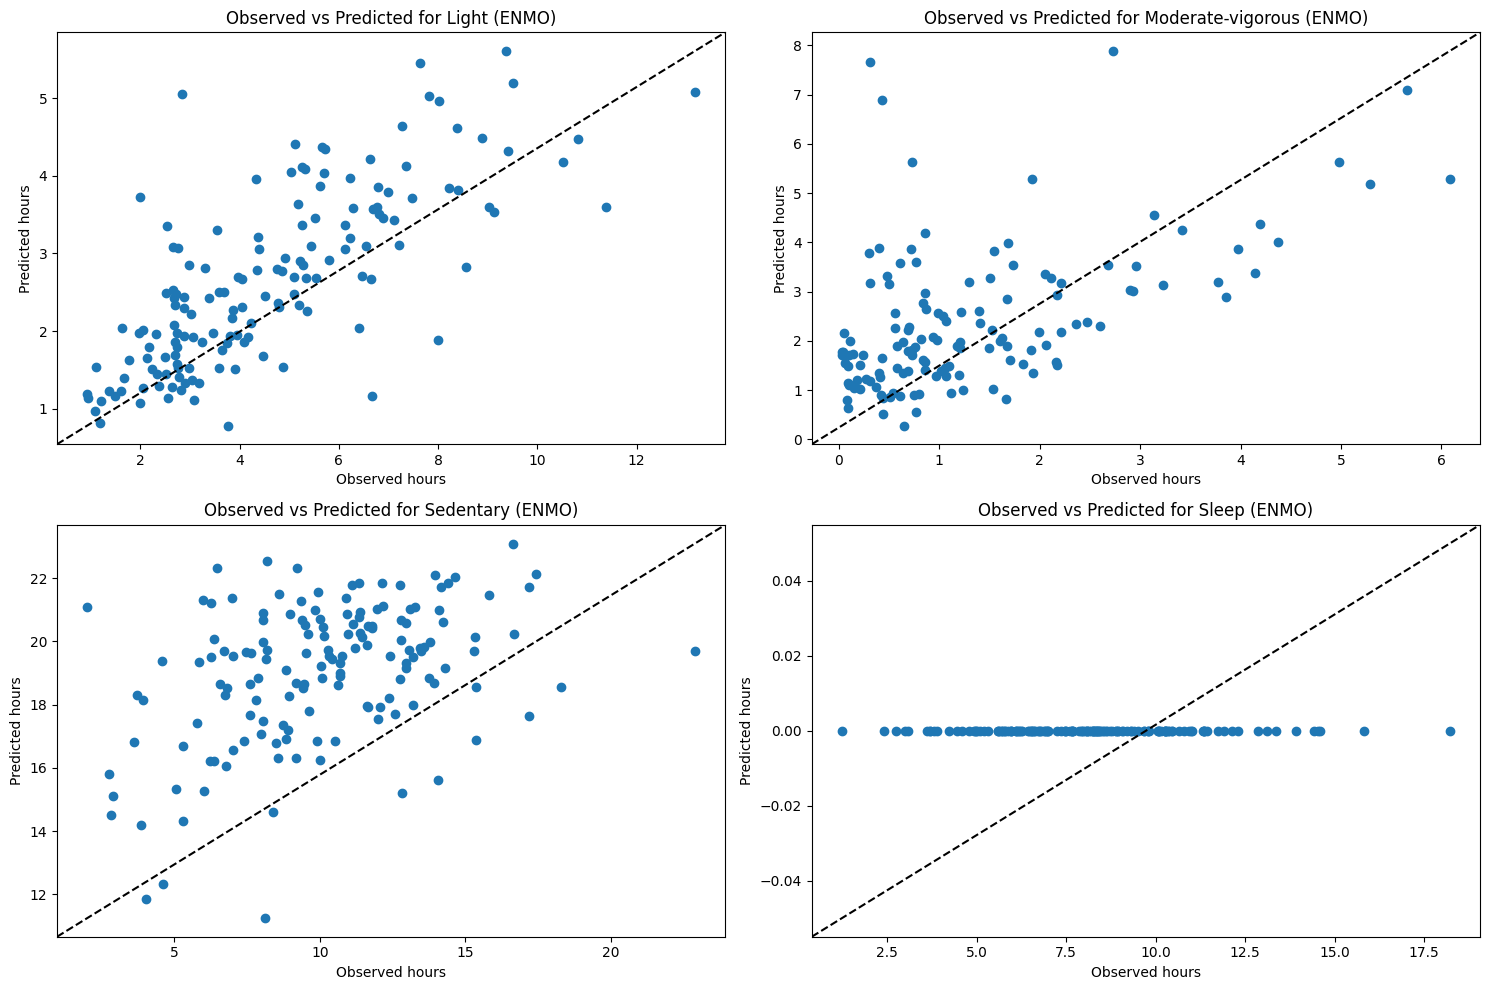

In [14]:
import matplotlib.pyplot as plt

# Scatter plots for each classification
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    observed = annotation_proportions[classification]
    predicted = cp_proportions[classification]
        
    ax.scatter(observed, predicted)
    ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (ENMO)')
    ax.set_xlabel('Observed hours')
    ax.set_ylabel('Predicted hours')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')
    
    # if classification=="moderate-vigorous":
    #     ax.plot([0, 0.4], [0, 0.4], 'r--')  # Diagonal line for reference
    # else:
    #     ax.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
    
plt.tight_layout()
plt.show()


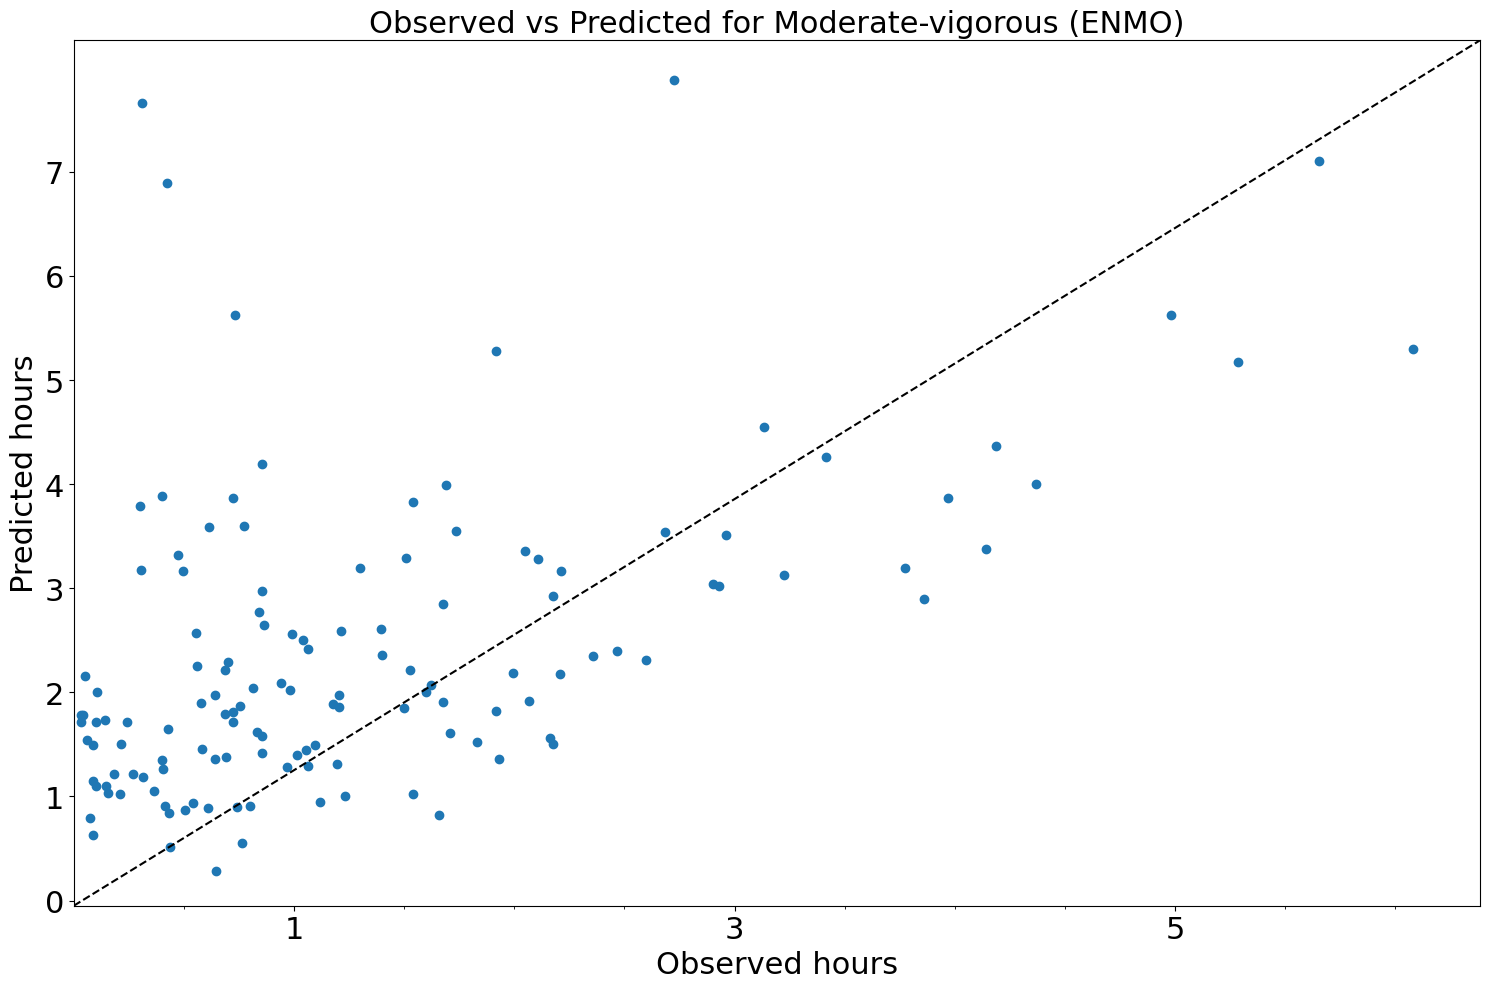

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Scatter plots for each classification
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

classifications = ["moderate-vigorous"]
for i, classification in enumerate(classifications):
    ax = axs
    
    observed = annotation_proportions[classification]
    predicted = cp_proportions[classification]
        
    ax.scatter(observed, predicted)
    ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (ENMO)', fontsize=22)
    ax.set_xlabel('Observed hours', fontsize=22)
    ax.set_ylabel('Predicted hours', fontsize=22)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=-0.05) # so that markers are not cut by half at the bottom axis.
    ax.set_xticks(np.arange(1, max(observed), 2.0))
    ax.set_yticks(np.arange(0, max(predicted), 1.0))
    ax.tick_params(axis='both', which='major', labelsize=22)      
    
    # if classification=="moderate-vigorous":
    #     ax.plot([0, 0.4], [0, 0.4], 'r--')  # Diagonal line for reference
    # else:
    #     ax.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
    
plt.tight_layout()
plt.show()


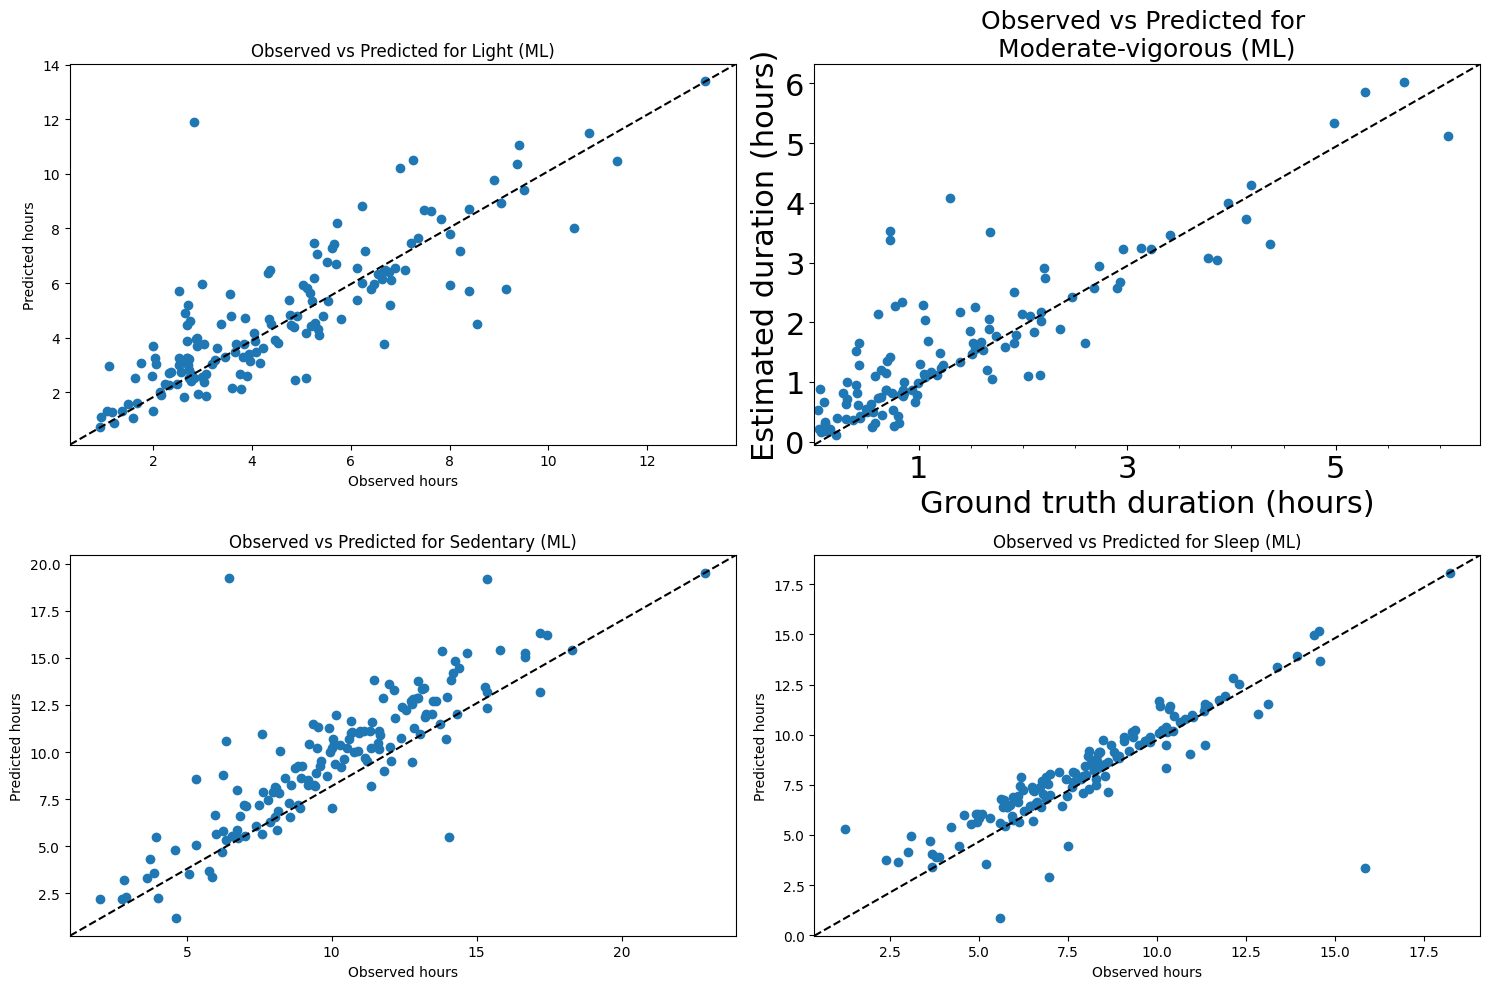

In [16]:
import matplotlib.pyplot as plt


# Scatter plots for each classification
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    observed = annotation_proportions[classification]
    predicted = walmsley_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=22
        ax.set_title(f'Observed vs Predicted for \n{classification.capitalize()} (ML)', fontsize=18)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05)  # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)

    else:
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (ML)')    
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference

plt.tight_layout()
plt.show()


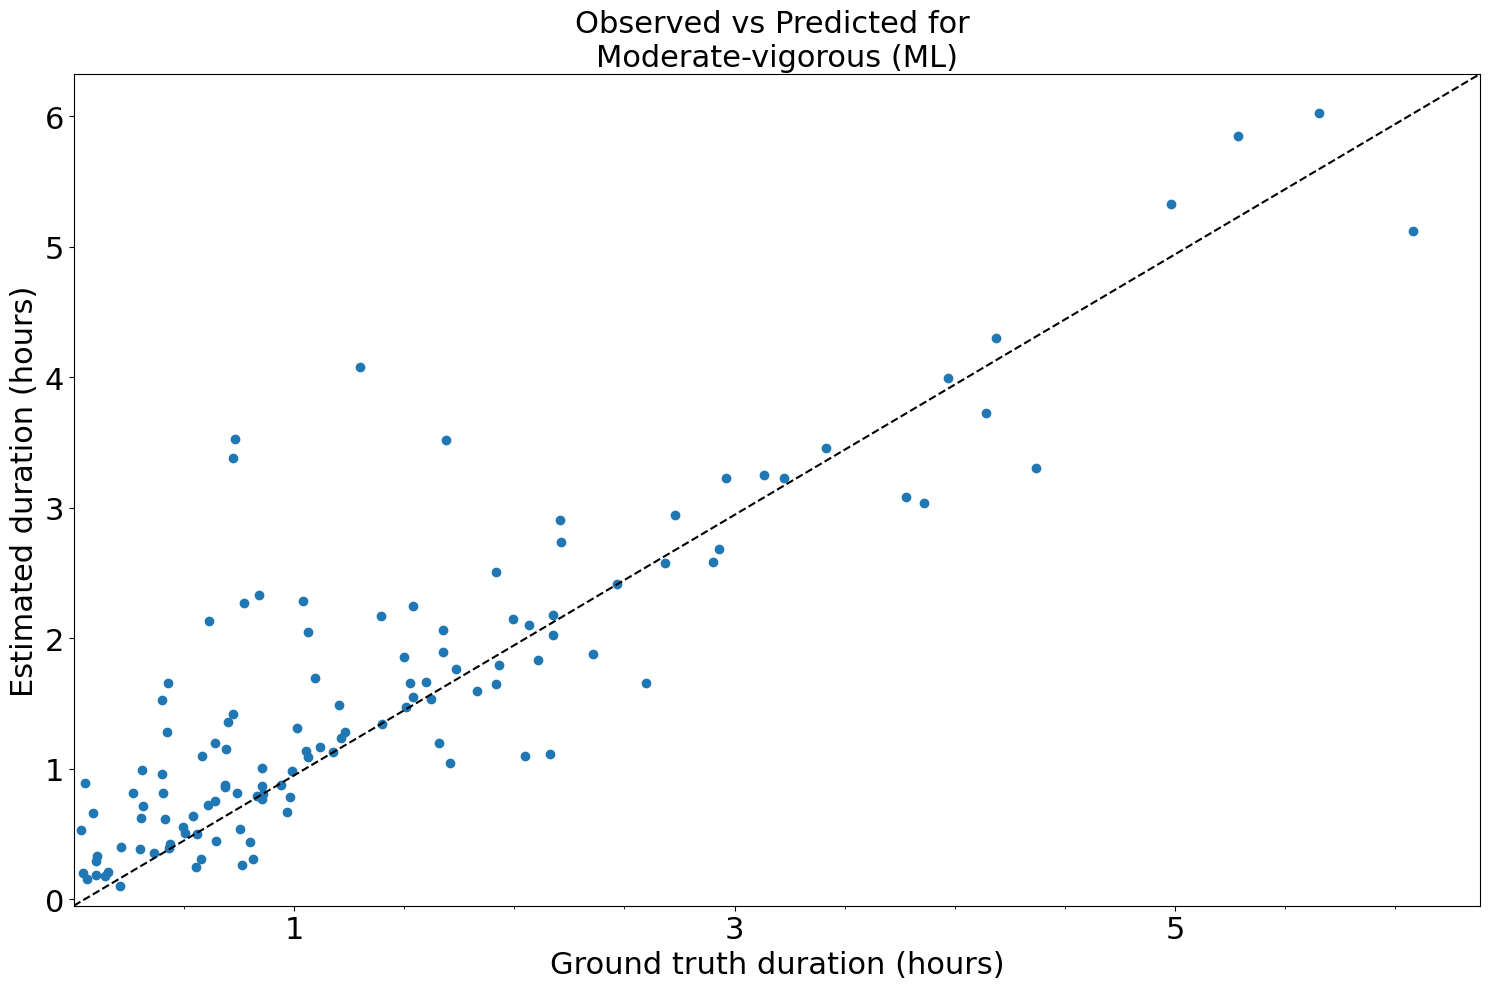

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Scatter plots for each classification
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
classifications = ["moderate-vigorous"]
for i, classification in enumerate(classifications):
    ax = axs
    
    observed = annotation_proportions[classification]
    predicted = walmsley_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=22
        ax.set_title(f'Observed vs Predicted for \n{classification.capitalize()} (ML)', fontsize=22)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05)  # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)

    else:
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (ML)')    
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference

plt.tight_layout()
plt.show()


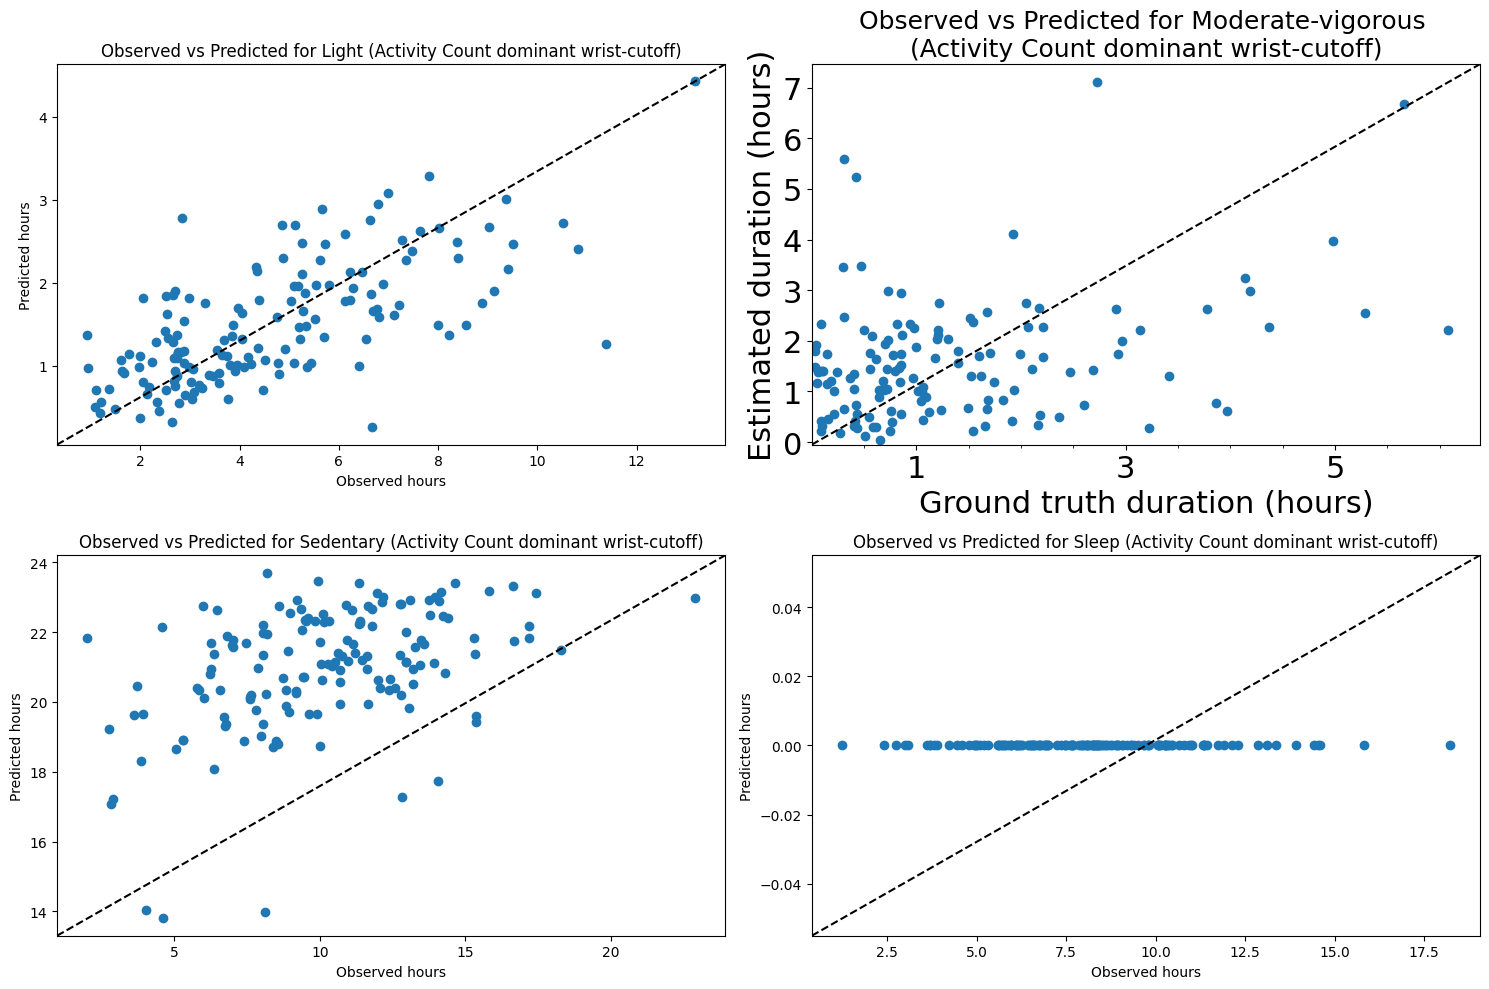

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Scatter plots for each classification
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    observed = annotation_proportions[classification]
    predicted = PA3_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=22
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} \n(Activity Count dominant wrist-cutoff)', fontsize=18)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05) # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)        
        
        
    else:
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (Activity Count dominant wrist-cutoff)')        
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')

plt.tight_layout()
plt.show()


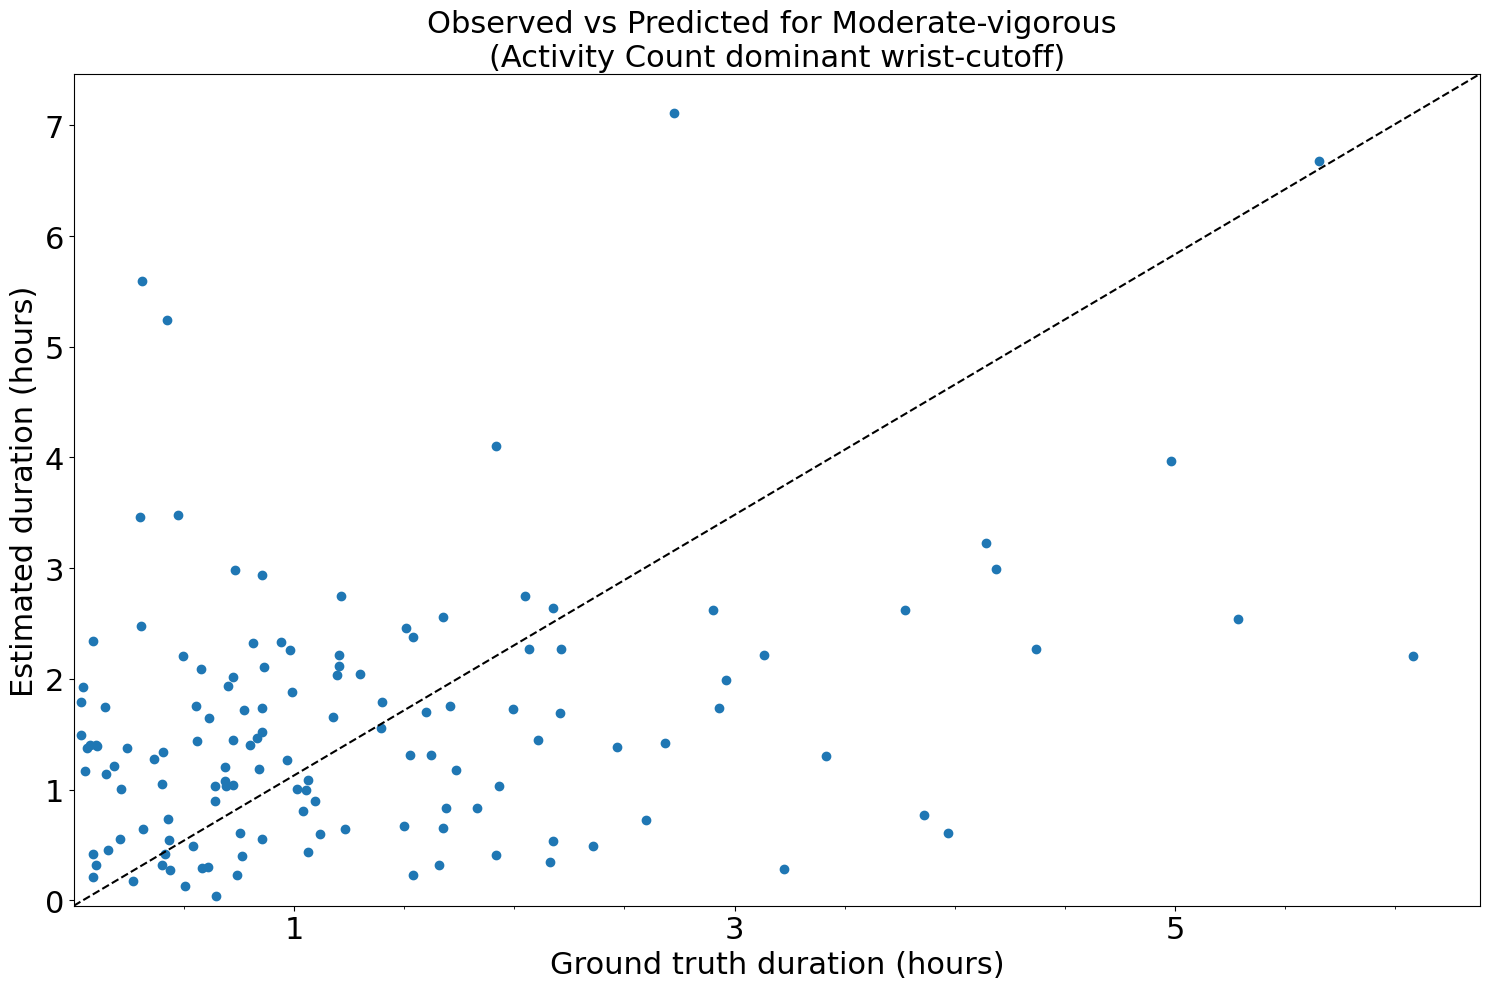

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Scatter plots for each classification
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
classifications = ["moderate-vigorous"]
for i, classification in enumerate(classifications):
    ax = axs
    
    observed = annotation_proportions[classification]
    predicted = PA3_proportions[classification]
        
    ax.scatter(observed, predicted)

    if classification=="moderate-vigorous":
        fsize=22
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} \n(Activity Count dominant wrist-cutoff)', fontsize=22)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Ground truth duration (hours)', fontsize=fsize)
        ax.set_ylabel('Estimated duration (hours)', fontsize=fsize)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(xmin=0)
        ax.set_ylim(ymin=-0.05) # so that markers are not cut by half at the bottom axis.
        ax.set_xticks(np.arange(1, max(observed), 2.0))
        ax.set_yticks(np.arange(0, max(predicted), 1.0))
        ax.tick_params(axis='both', which='major', labelsize=fsize)        
        
        
    else:
        ax.set_title(f'Observed vs Predicted for {classification.capitalize()} (Activity Count dominant wrist-cutoff)')        
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black')  # Diagonal line for reference
        ax.set_xlabel('Observed hours')
        ax.set_ylabel('Predicted hours')

plt.tight_layout()
plt.show()


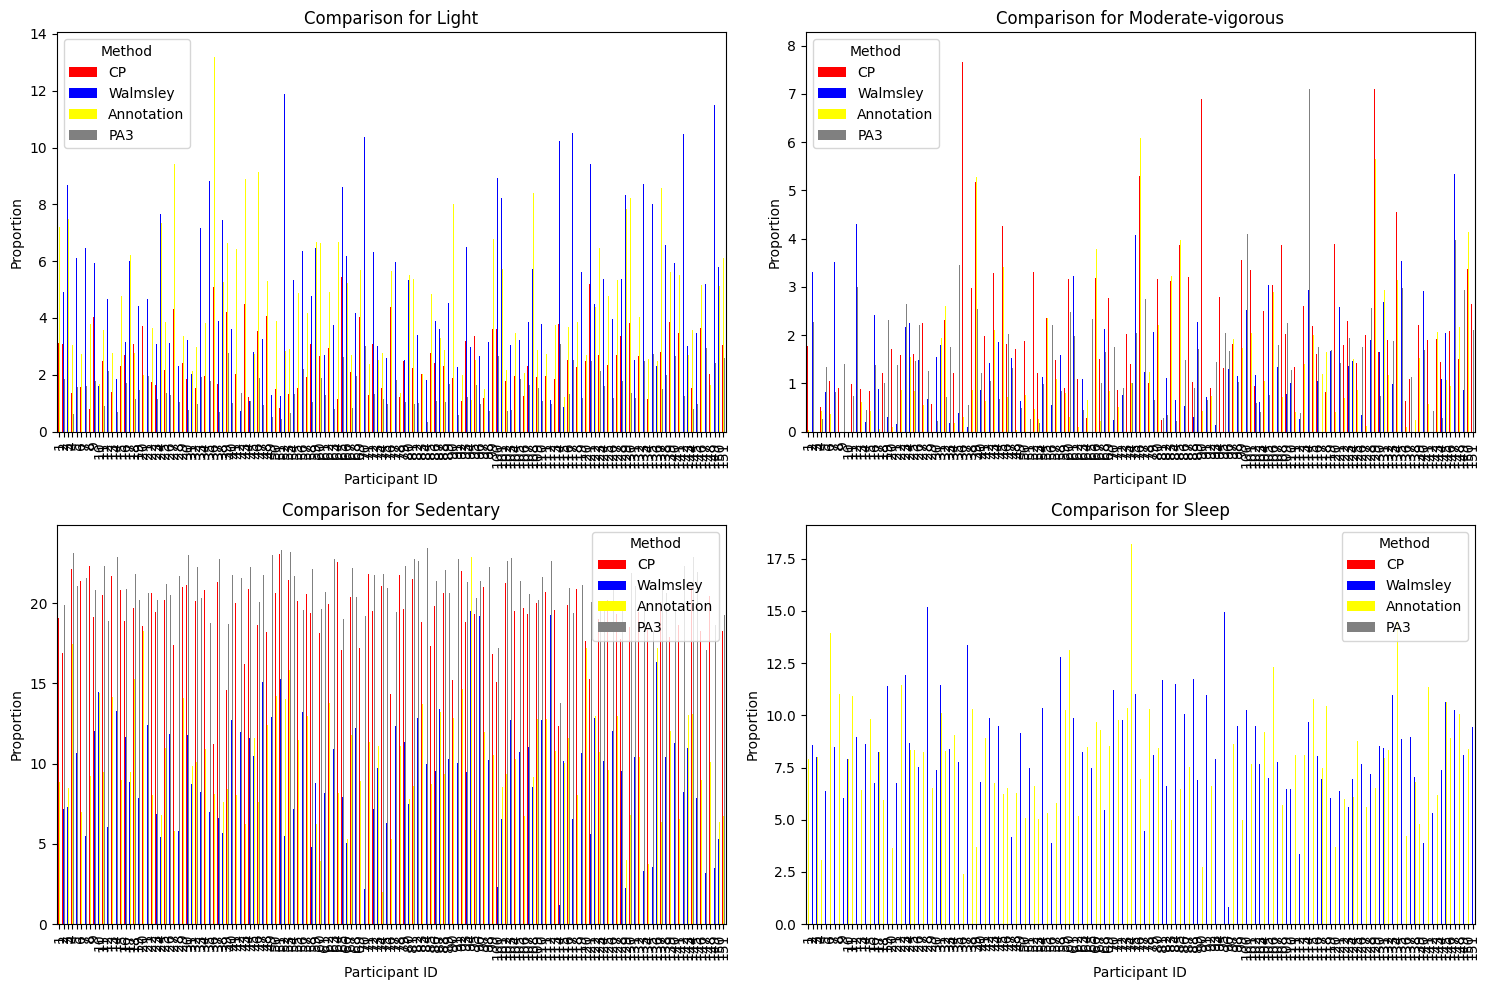

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# already set
# cp_proportions = cp_proportions.set_index("participant_id")
# walmsley_proportions = walmsley_proportions.set_index("participant_id")
# annotation_proportions = annotation_proportions.set_index("participant_id")

# List of classifications
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]

# Plotting the bar graphs
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
colors = ['red', 'blue', 'yellow', 'grey'] 
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    cp_data = cp_proportions[classification] if classification in cp_proportions.columns else [0] * len(cp_proportions)
    walmsley_data = walmsley_proportions[classification] if classification in walmsley_proportions.columns else [0] * len(walmsley_proportions)
    annotation_data = annotation_proportions[classification] if classification in annotation_proportions.columns else [0] * len(annotation_proportions)
    PA3_data = PA3_proportions[classification] if classification in PA3_proportions.columns else [0] * len(PA3_proportions)
    
    df = pd.DataFrame({
        "CP": cp_data,
        "Walmsley": walmsley_data,
        "Annotation": annotation_data,
        "PA3": PA3_data
    }, index=cp_proportions.index)
    
    df.plot(kind='bar', ax=ax, title=f'Comparison for {classification.capitalize()}', color=colors)
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Proportion")
    ax.legend(title="Method")

plt.tight_layout()
plt.show()
